<a href="https://colab.research.google.com/github/denisakatov/Data-analysis-on-Kaggle/blob/main/hm5_sport_analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
from tqdm import tqdm
from typing import List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
liderboard = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle /2/data/assignment_2_test.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle /2/data/assignment_2_train.csv')

In [3]:
# Категориальные признаки для train переводим в category для возможности обработки категориальных признаков lightgbm

for c in liderboard.select_dtypes(include=[np.object]):
  liderboard[c] = liderboard[c].astype('category')

In [4]:
train.head(2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
Y = train.isFraud
X = train.drop(['isFraud'], axis=1)

In [6]:
print('Датасет состоит из {} строк и {} столбцов'.format(*X.shape))

Датасет состоит из 180000 строк и 393 столбцов


In [7]:
# Категориальные признаки переводим в category для возможности обработки категориальных признаков lightgbm
X_category = X.select_dtypes(include=[np.object])

for c in X_category:
  X[c] = X[c].astype('category')

In [8]:
X.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
X.head(2)

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_estimators": 200,
    "n_jobs": 6,
    "seed": 27
}

In [11]:
x_train, x_valid = train_test_split(X,train_size=0.7,shuffle=True,random_state = 1,)
y_train, y_valid = train_test_split(Y, train_size=0.7, shuffle=True, random_state=1,)
dtrain = lgb.Dataset(data=x_train, label=y_train)
dvalid = lgb.Dataset(data=x_valid, label=y_valid)

model = lgb.train(
      params=params,
      train_set=dtrain,
      num_boost_round=200,
      valid_sets=[dtrain, dvalid],
      categorical_feature="auto",
      early_stopping_rounds=50,
      verbose_eval=10
        )
  


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.835413	valid_1's auc: 0.829611
[20]	training's auc: 0.851371	valid_1's auc: 0.842652
[30]	training's auc: 0.871352	valid_1's auc: 0.862668
[40]	training's auc: 0.879627	valid_1's auc: 0.868971
[50]	training's auc: 0.885162	valid_1's auc: 0.873931
[60]	training's auc: 0.888298	valid_1's auc: 0.877464
[70]	training's auc: 0.890777	valid_1's auc: 0.880339
[80]	training's auc: 0.897042	valid_1's auc: 0.885193
[90]	training's auc: 0.900175	valid_1's auc: 0.887796
[100]	training's auc: 0.903054	valid_1's auc: 0.890553
[110]	training's auc: 0.905344	valid_1's auc: 0.89237
[120]	training's auc: 0.907317	valid_1's auc: 0.894338
[130]	training's auc: 0.90919	valid_1's auc: 0.896449
[140]	training's auc: 0.911355	valid_1's auc: 0.898517
[150]	training's auc: 0.913852	valid_1's auc: 0.900294
[160]	training's auc: 0.916032	valid_1's auc: 0.901372
[170]	training's auc: 0.917735	valid_1's auc: 0.902415
[180]	training

In [12]:
liderboard_score = roc_auc_score(Y, model.predict(X))

In [13]:
liderboard_score

0.9175036562846264

In [14]:
train_score = roc_auc_score(y_train, model.predict(x_train))
valid_score = roc_auc_score(y_valid, model.predict(x_valid))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)}, Liderboard_score: {round(liderboard_score, 3)}")

Train-score: 0.923, Valid-score: 0.905, Liderboard_score: 0.918


## Задание 1: признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.

In [15]:
import datetime

In [16]:
base_date = datetime.date(2017,12,1)

In [17]:
base_date

datetime.date(2017, 12, 1)

In [18]:
X['TransactionDT_datetime'] = pd.to_datetime(X['TransactionDT'].apply(lambda x: base_date - datetime.timedelta(seconds=x)))

In [19]:
X['year'], X['month'], X['day'] = X['TransactionDT_datetime'].dt.year,\
                         X['TransactionDT_datetime'].dt.month, X['TransactionDT_datetime'].dt.day

In [20]:
X[['year', 'month', 'day']].head(2)

,year,month,day
0,2017,11,30
1,2017,11,30


In [21]:
for c in X[['year', 'month', 'day']]:
    X[c] = X[c].astype('category')

In [22]:
X = X.drop(['TransactionDT_datetime', 'TransactionDT'],axis=1)

In [23]:
x_train1, x_valid1 = train_test_split(X, train_size=0.7, shuffle=True, random_state=1,)
y_train1, y_valid1 = train_test_split(Y, train_size=0.7, shuffle=True, random_state=1,)
dtrain1 = lgb.Dataset(data=x_train1, label=y_train1)
dvalid1 = lgb.Dataset(data=x_valid1, label=y_valid1)

model1 = lgb.train(
      params=params,
      train_set=dtrain1,
      num_boost_round=200,
      valid_sets=[dtrain1, dvalid1],
      categorical_feature="auto",
      early_stopping_rounds=50,
      verbose_eval=10,
        )


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.835413	valid_1's auc: 0.829611
[20]	training's auc: 0.85137	valid_1's auc: 0.842652
[30]	training's auc: 0.871406	valid_1's auc: 0.862735
[40]	training's auc: 0.880225	valid_1's auc: 0.869378
[50]	training's auc: 0.8855	valid_1's auc: 0.874277
[60]	training's auc: 0.888351	valid_1's auc: 0.877857
[70]	training's auc: 0.890667	valid_1's auc: 0.880285
[80]	training's auc: 0.89696	valid_1's auc: 0.884675
[90]	training's auc: 0.900316	valid_1's auc: 0.887053
[100]	training's auc: 0.903403	valid_1's auc: 0.889533
[110]	training's auc: 0.905459	valid_1's auc: 0.891646
[120]	training's auc: 0.90789	valid_1's auc: 0.893914
[130]	training's auc: 0.910175	valid_1's auc: 0.89638
[140]	training's auc: 0.912137	valid_1's auc: 0.898238
[150]	training's auc: 0.914199	valid_1's auc: 0.899801
[160]	training's auc: 0.916435	valid_1's auc: 0.901311
[170]	training's auc: 0.919091	valid_1's auc: 0.902392
[180]	training's a

In [24]:
liderboard_score1 = roc_auc_score(Y, model1.predict(X))
train_score1 = roc_auc_score(y_train1, model1.predict(x_train1))
valid_score1 = roc_auc_score(y_valid1, model1.predict(x_valid1))

### Задание 2: сделать конкатенацию признаков
* card1 + card2;
* card1 + card2 + card_3 + card_5;
* card1 + card2 + card_3 + card_5 + addr1 + addr2

Рассматривать их как категориальных признаки.

In [25]:
X['card1_2']=X['card1']+X['card2']
X['card1_2'] =X['card1_2'].astype('category')

Если необходимо сконкатенировать просто имена, то можно использовать код ниже.

In [26]:
# X['card1_2']=X['card1'].astype(np.str)+'_'+X['card2'].astype(np.str)
# X['card1_2'] = X['card1_2'].astype('category')

In [27]:
X['card1_2']

0             NaN
1          3159.0
2          5153.0
3         18699.0
4          5011.0
           ...   
179995     2187.0
179996    10589.0
179997     6175.0
179998     8281.0
179999    18008.0
Name: card1_2, Length: 180000, dtype: category
Categories (7534, float64): [1134.0, 1149.0, 1187.0, 1309.0, ..., 18938.0, 18940.0, 18943.0, 18948.0]

In [28]:
X['card1_2_3_5']=X['card1']+X['card2']+X['card3']+X['card5']
X['card1_2_3_5'] = X['card1_2_3_5'].astype('category')

In [29]:
X['card1_2_3_5_addr1_2']=X['card1']+X['card2']+X['card3']+X['card5']+X['addr1']+X['addr2']
X['card1_2_3_5_addr1_2'] = X['card1_2_3_5_addr1_2'].astype('category')

In [30]:
x_train2, x_valid2 = train_test_split(X,train_size=0.7,shuffle=True,random_state = 1,)
y_train2, y_valid2 = train_test_split(Y,train_size=0.7, shuffle=True, random_state=1,)
dtrain2 = lgb.Dataset(data=x_train2, label=y_train2)
dvalid2 = lgb.Dataset(data=x_valid2, label=y_valid2)

model2 = lgb.train(
      params=params,
      train_set=dtrain2,
      num_boost_round=200,
      valid_sets=[dtrain2, dvalid2],
      categorical_feature="auto",
      early_stopping_rounds=50,
      verbose_eval=10
        )


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.865399	valid_1's auc: 0.836636
[20]	training's auc: 0.88348	valid_1's auc: 0.85006
[30]	training's auc: 0.900615	valid_1's auc: 0.865745
[40]	training's auc: 0.907189	valid_1's auc: 0.871459
[50]	training's auc: 0.914394	valid_1's auc: 0.877471
[60]	training's auc: 0.9214	valid_1's auc: 0.883235
[70]	training's auc: 0.929313	valid_1's auc: 0.889867
[80]	training's auc: 0.938018	valid_1's auc: 0.899268
[90]	training's auc: 0.942963	valid_1's auc: 0.902628
[100]	training's auc: 0.947075	valid_1's auc: 0.905832
[110]	training's auc: 0.950679	valid_1's auc: 0.90822
[120]	training's auc: 0.953414	valid_1's auc: 0.910155
[130]	training's auc: 0.955571	valid_1's auc: 0.912073
[140]	training's auc: 0.957563	valid_1's auc: 0.913804
[150]	training's auc: 0.959384	valid_1's auc: 0.915507
[160]	training's auc: 0.961009	valid_1's auc: 0.916794
[170]	training's auc: 0.962732	valid_1's auc: 0.91843
[180]	training's a

In [31]:
liderboard_score2 = roc_auc_score(Y, model2.predict(X))
train_score2 = roc_auc_score(y_train2, model2.predict(x_train2))
valid_score2 = roc_auc_score(y_valid2, model2.predict(x_valid2))

### Задание 3: Сделать FrequencyEncoder для признаков card1 - card6, addr1, addr2.

In [32]:
def frequency_encoder(X, features):
    X = X.copy()
    for f in features:
        name = f'{f}_frequency'
        print(name)
        X[name] = X[f].map(X[f].value_counts(normalize=True))
    return X


In [33]:
features = ['card1', 'card2','card3','card4','card5','card6', 'addr1', 'addr2']

In [34]:
X = frequency_encoder(X, features)


card1_frequency
card2_frequency
card3_frequency
card4_frequency
card5_frequency
card6_frequency
addr1_frequency
addr2_frequency


In [35]:
X.head()

,TransactionID,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,year,month,day,card1_2,card1_2_3_5,card1_2_3_5_addr1_2,card1_frequency,card2_frequency,card3_frequency,card4_frequency,card5_frequency,card6_frequency,addr1_frequency,addr2_frequency
0,2987000,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,...,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,11,30,NaN,NaN,NaN,0.000061,NaN,0.879737,0.013212,0.000274,0.317951,0.042773,0.982344
1,2987001,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,11,30,3159.0,3411.0,3823.0,0.001244,0.006855,0.879737,0.302797,0.054723,0.317951,0.080004,0.982344
2,2987002,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,11,30,5153.0,5469.0,5886.0,0.001428,0.061413,0.879737,0.657224,0.080269,0.681949,0.046205,0.982344
3,2987003,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,...,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,11,30,18699.0,18966.0,19529.0,0.006600,0.010012,0.879737,0.302797,0.037303,0.681949,0.017276,0.982344
4,2987004,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017,11,30,5011.0,5263.0,5770.0,0.000011,0.030836,0.879737,0.302797,0.054723,0.317951,0.007810,0.982344


In [36]:
x_train3, x_valid3 = train_test_split(X,train_size=0.7,shuffle=True,random_state = 1,)
y_train3, y_valid3 = train_test_split(Y,train_size=0.7, shuffle=True, random_state=1,)
dtrain3 = lgb.Dataset(data=x_train3, label=y_train3)
dvalid3 = lgb.Dataset(data=x_valid3, label=y_valid3)

model3 = lgb.train(
      params=params,
      train_set=dtrain3,
      num_boost_round=200,
      valid_sets=[dtrain3, dvalid3],
      categorical_feature="auto",
      early_stopping_rounds=50,
      verbose_eval=10
        )


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.862731	valid_1's auc: 0.835382
[20]	training's auc: 0.88699	valid_1's auc: 0.852141
[30]	training's auc: 0.900816	valid_1's auc: 0.865044
[40]	training's auc: 0.907569	valid_1's auc: 0.873397
[50]	training's auc: 0.917337	valid_1's auc: 0.881773
[60]	training's auc: 0.921285	valid_1's auc: 0.88334
[70]	training's auc: 0.93106	valid_1's auc: 0.890855
[80]	training's auc: 0.937211	valid_1's auc: 0.897608
[90]	training's auc: 0.943129	valid_1's auc: 0.90285
[100]	training's auc: 0.947839	valid_1's auc: 0.906082
[110]	training's auc: 0.952238	valid_1's auc: 0.909784
[120]	training's auc: 0.955148	valid_1's auc: 0.911963
[130]	training's auc: 0.95722	valid_1's auc: 0.914053
[140]	training's auc: 0.95904	valid_1's auc: 0.915638
[150]	training's auc: 0.96087	valid_1's auc: 0.917047
[160]	training's auc: 0.96297	valid_1's auc: 0.918904
[170]	training's auc: 0.964462	valid_1's auc: 0.920106
[180]	training's auc

In [37]:
liderboard_score3 = roc_auc_score(Y, model3.predict(X))
train_score3 = roc_auc_score(y_train3, model3.predict(x_train3))
valid_score3 = roc_auc_score(y_valid3, model3.predict(x_valid3))

### Задание 4: Создать признаки на основе отношения: TransactionAmt к вычисленной статистике. Статистика - среднее значение / стандартное отклонение TransactionAmt, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [38]:
features = ['card1', 'card2','card3','card4','card5','card6', 'addr1', 'addr2','card1_2_3_5','card1_2','card1_2_3_5_addr1_2']

In [39]:
def std_features(x,features):
    for f in features:
        name = f'{f}_Std'
        X[name] = X[f].map(X.groupby([f])['TransactionAmt'].std())
        return X

def mean_features(x,features):
    for f in features:
        name = f'{f}_Mean'
        X[name] = X[f].map(X.groupby([f])['TransactionAmt'].mean())
        return X


In [40]:
X = std_features(X, features)
X = mean_features(X, features)

Just to check

In [41]:
X['card1_Mean']

0         193.227273
1         229.588080
2          88.574163
3         112.887660
4          40.000000
             ...    
179995     58.534000
179996    146.116966
179997    166.518073
179998     49.400000
179999    238.074385
Name: card1_Mean, Length: 180000, dtype: float64

In [42]:
x_train4, x_valid4 = train_test_split(X,train_size=0.7,shuffle=True,random_state = 1,)
y_train4, y_valid4 = train_test_split(Y,train_size=0.7, shuffle=True, random_state=1,)
dtrain4 = lgb.Dataset(data=x_train4, label=y_train4)
dvalid4 = lgb.Dataset(data=x_valid4, label=y_valid4)

model4 = lgb.train(
      params=params,
      train_set=dtrain4,
      num_boost_round=200,
      valid_sets=[dtrain4, dvalid4],
      categorical_feature="auto",
      early_stopping_rounds=50,
      verbose_eval=10
        )


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.862731	valid_1's auc: 0.835382
[20]	training's auc: 0.885446	valid_1's auc: 0.851243
[30]	training's auc: 0.900488	valid_1's auc: 0.864626
[40]	training's auc: 0.905145	valid_1's auc: 0.870206
[50]	training's auc: 0.914813	valid_1's auc: 0.87863
[60]	training's auc: 0.917588	valid_1's auc: 0.879687
[70]	training's auc: 0.925924	valid_1's auc: 0.884811
[80]	training's auc: 0.938727	valid_1's auc: 0.899986
[90]	training's auc: 0.943518	valid_1's auc: 0.904482
[100]	training's auc: 0.948028	valid_1's auc: 0.907061
[110]	training's auc: 0.95206	valid_1's auc: 0.910226
[120]	training's auc: 0.954719	valid_1's auc: 0.912134
[130]	training's auc: 0.956786	valid_1's auc: 0.91348
[140]	training's auc: 0.958932	valid_1's auc: 0.916141
[150]	training's auc: 0.96086	valid_1's auc: 0.918209
[160]	training's auc: 0.962949	valid_1's auc: 0.919622
[170]	training's auc: 0.964276	valid_1's auc: 0.920471
[180]	training's

In [43]:
liderboard_score4 = roc_auc_score(Y, model4.predict(X))


In [44]:
train_score4 = roc_auc_score(y_train4, model4.predict(x_train4))
valid_score4 = roc_auc_score(y_valid4, model4.predict(x_valid4))

### Задание 5: Создать признаки на основе отношения: D15 к вычисленной статистике. Статистика - среднее значение / стандартное отклонение D15, сгруппированное по card1 - card6, addr1, addr2, и по признакам, созданным в задании 2.

In [45]:
def std_features_D15(x):
    for f in features:
        name = f'{f}_D15_Std'
        X[name] = X[f].map(X.groupby([f])['D15'].std())
        return X

def mean_features_D15(x):
    for f in features:
        name = f'{f}_D15_Mean'
        X[name] = X[f].map(X.groupby([f])['D15'].mean())
        return X


In [46]:
X = std_features(X, features)
X = mean_features(X, features)

In [47]:
x_train5, x_valid5 = train_test_split(X,train_size=0.7,shuffle=True,random_state = 1,)
y_train5, y_valid5 = train_test_split(Y,train_size=0.7, shuffle=True, random_state=1,)
dtrain5 = lgb.Dataset(data=x_train5, label=y_train5)
dvalid5 = lgb.Dataset(data=x_valid5, label=y_valid5)

model5 = lgb.train(
      params=params,
      train_set=dtrain5,
      num_boost_round=200,
      valid_sets=[dtrain5, dvalid5],
      categorical_feature="auto",
      early_stopping_rounds=50,
      verbose_eval=10
        )


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.862731	valid_1's auc: 0.835382
[20]	training's auc: 0.885446	valid_1's auc: 0.851243
[30]	training's auc: 0.900488	valid_1's auc: 0.864626
[40]	training's auc: 0.905145	valid_1's auc: 0.870206
[50]	training's auc: 0.914813	valid_1's auc: 0.87863
[60]	training's auc: 0.917588	valid_1's auc: 0.879687
[70]	training's auc: 0.925924	valid_1's auc: 0.884811
[80]	training's auc: 0.938727	valid_1's auc: 0.899986
[90]	training's auc: 0.943518	valid_1's auc: 0.904482
[100]	training's auc: 0.948028	valid_1's auc: 0.907061
[110]	training's auc: 0.95206	valid_1's auc: 0.910226
[120]	training's auc: 0.954719	valid_1's auc: 0.912134
[130]	training's auc: 0.956786	valid_1's auc: 0.91348
[140]	training's auc: 0.958932	valid_1's auc: 0.916141
[150]	training's auc: 0.96086	valid_1's auc: 0.918209
[160]	training's auc: 0.962949	valid_1's auc: 0.919622
[170]	training's auc: 0.964276	valid_1's auc: 0.920471
[180]	training's

In [48]:
liderboard_score4 = roc_auc_score(Y, model5.predict(X))


In [49]:
train_score5 = roc_auc_score(y_train5, model5.predict(x_train5))
valid_score5 = roc_auc_score(y_valid5, model5.predict(x_valid5))

### Задание 6: выделить дробную часть и целую часть признака TransactionAmt в два отдельных признака. После создать отдельных признак - логарифм от TransactionAmt

In [50]:
def TransactionAmt_Fraction(x):
    x = x.copy()
    x['TransactionAmt_whole'] = x['TransactionAmt']//1
    x['TransactionAmt_frac'] = x['TransactionAmt']%1
    x['TransactionAmt_log'] = np.log(x['TransactionAmt'])
    return x

In [51]:
X = TransactionAmt_Fraction(X)

In [52]:
x_train6, x_valid6 = train_test_split(X,train_size=0.7,shuffle=True,random_state = 1,)
y_train6, y_valid6 = train_test_split(Y,train_size=0.7, shuffle=True, random_state=1,)
dtrain6 = lgb.Dataset(data=x_train6, label=y_train6)
dvalid6 = lgb.Dataset(data=x_valid6, label=y_valid6)

model6 = lgb.train(
      params=params,
      train_set=dtrain6,
      num_boost_round=200,
      valid_sets=[dtrain6, dvalid6],
      categorical_feature="auto",
      early_stopping_rounds=50,
      verbose_eval=10
        )


Training until validation scores don't improve for 50 rounds.
[10]	training's auc: 0.862731	valid_1's auc: 0.835382
[20]	training's auc: 0.885446	valid_1's auc: 0.851243
[30]	training's auc: 0.900487	valid_1's auc: 0.864626
[40]	training's auc: 0.905145	valid_1's auc: 0.870206
[50]	training's auc: 0.914813	valid_1's auc: 0.87863
[60]	training's auc: 0.917583	valid_1's auc: 0.879566
[70]	training's auc: 0.930138	valid_1's auc: 0.892567
[80]	training's auc: 0.93733	valid_1's auc: 0.899611
[90]	training's auc: 0.943048	valid_1's auc: 0.904679
[100]	training's auc: 0.947219	valid_1's auc: 0.907507
[110]	training's auc: 0.951759	valid_1's auc: 0.910721
[120]	training's auc: 0.954352	valid_1's auc: 0.912088
[130]	training's auc: 0.956587	valid_1's auc: 0.913994
[140]	training's auc: 0.958711	valid_1's auc: 0.91509
[150]	training's auc: 0.96063	valid_1's auc: 0.917052
[160]	training's auc: 0.962612	valid_1's auc: 0.918355
[170]	training's auc: 0.964308	valid_1's auc: 0.92
[180]	training's auc

In [53]:
train_score6 = roc_auc_score(y_train6, model6.predict(x_train6))
valid_score6 = roc_auc_score(y_valid6, model6.predict(x_valid6))

And compare

In [54]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(
    y_train, model.predict(x_train)
)
fpr1, tpr1, _ = roc_curve(
    y_train1, model1.predict(x_train1)
)
fpr2, tpr2, _ = roc_curve(
    y_train2, model2.predict(x_train2)
)
fpr3, tpr3, _ = roc_curve(
    y_train3, model3.predict(x_train3)
)

fpr4, tpr4, _ = roc_curve(
    y_train4, model4.predict(x_train4)
)


fpr5, tpr5, _ = roc_curve(
    y_train5, model5.predict(x_train5)
)


fpr6, tpr6, _ = roc_curve(
    y_train6, model6.predict(x_train6)
)


fpr6, tpr6, _ = roc_curve(
    y_train6, model6.predict(x_train6)
)



(0.0, 1.0)

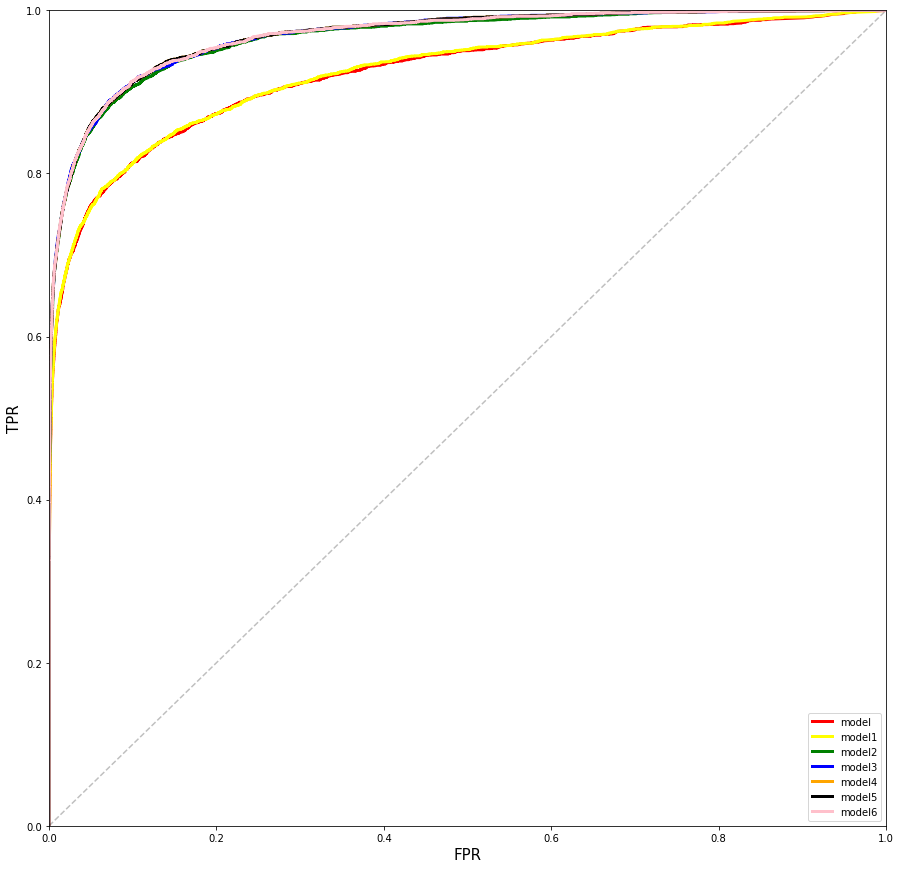

In [59]:
fig = plt.figure(figsize=(15, 15))
plt.plot(fpr, tpr, linewidth=3, color="red", label="model")
plt.plot(fpr1, tpr1, linewidth=3, color="yellow", label="model1")
plt.plot(fpr2, tpr2, linewidth=3, color="green", label="model2")
plt.plot(fpr3, tpr3, linewidth=3, color="blue", label="model3")
plt.plot(fpr4, tpr4, linewidth=3, color="orange", label="model4")
plt.plot(fpr5, tpr5, linewidth=3, color="black", label="model5")
plt.plot(fpr6, tpr6, linewidth=3, color="pink", label="model6")
plt.plot([0, 1], [0, 1], linestyle="--", color="black", alpha=0.25)
plt.xlabel("FPR", size=15)
plt.ylabel("TPR", size=15)
plt.legend(loc="best")
plt.xlim(0, 1)
plt.ylim(0, 1)

##According to chart results of model2, model3,model4,model5,model6 are better then model and model1

In [56]:
print(f'Модель:   {train_score} {valid_score}') 
print(f'Модель 1: {train_score1} {valid_score1}') 
print(f'Модель 2: {train_score2} {valid_score2}') 
print(f'Модель 3: {train_score3} {valid_score3}') 
print(f'Модель 4: {train_score4} {valid_score4}') 
print(f'Модель 5: {train_score5} {valid_score5}')
print(f'Модель 6: {train_score6} {valid_score6}') 

Модель:   0.9226391610117767 0.9051411598187495
Модель 1: 0.923678307821754 0.9048242644022177
Модель 2: 0.9663715156983425 0.9213519543088451
Модель 3: 0.9681856851494823 0.9234763770927892
Модель 4: 0.9683519555370956 0.9234458934491397
Модель 5: 0.9683519555370956 0.9234458934491397
Модель 6: 0.9681991903847054 0.9229873317241288


## Я бы сказал, что модель 3 лучше, так как результат на валидационной и тренировочной выборках ближе к друг другу

I would said that now model3 shows the best result